In [1]:
# This cell imports all necessary libraries for this code
import xarray as xr # library for loading netcdf files
import matplotlib.pyplot as plt # library for plotting 
import numpy as np # libary for working with arrays
import cartopy.crs as ccrs # library for plotting on maps
import matplotlib.ticker as mticker # library for putting axes labels
import math # math library

In [2]:
# define some constants
a = 6.37*10**6 # mean radius of the earth (meters)
omega = 7.272*10**-5 # earth rotation rate (rad/s)
pi = math.pi # pi

In [4]:
# This cell defines which file to read

# data that you want to load 
filename = 'era5.33N-48N.162W-135W.2006121400.nc'
# The first thing you want to do is to check what variables are stored in what formats. There are multiple ways to do so.
# method 1) go to terminal and type "ncdump -h filename" where the filename is the actual name of the file that you want to check.
# This will output information about store variables and attributes
# method 2) Check the file here using "xr.open_dataset(filename)".
# When you run this cell, the line below will output information about the data file
datafile = xr.open_dataset(filename)

In [5]:
# This cell loads dimensions of the data
lat = datafile.lat.data # latitude (degress north)
lon = datafile.lon.data # longitude (degrees east)
lev = datafile.lev.data # pressure level (hPa)
time = datafile.time.data # time
print(time)

['2006-12-14T00:00:00.000000000']


In [6]:
# This cell will load variables of the data
# loading one isobaric level (e.g., 850 hPa)
p0 = 850
u=datafile.u.sel(lev=p0).data[0,:,:] # zonal wind (m/s) with dimension lat x lon
v=datafile.v.sel(lev=p0).data[0,:,:] # meridional wind (m/s) with dimension lat x lon
w=datafile.w.sel(lev=p0).data[0,:,:] # vertical velocity (Pa/s)
G=datafile.g.sel(lev=p0).data[0,:,:] # geopotential (m^2 s^-2)
# for all these variables, I am only loading the first time index

# you also need to load u and v at levels above and below to calculate vertical gradients
p1 = lev[np.where(lev==p0)[0]-1] # one pressure level below p0
p2 = lev[np.where(lev==p0)[0]+1] # one pressure level above p0
u_lev1=datafile.u.sel(lev=p1).data[0,:,:] # vertical level below
v_lev1=datafile.v.sel(lev=p1).data[0,:,:] 
u_lev2=datafile.u.sel(lev=p2).data[0,:,:] # vertical level above
v_lev2=datafile.v.sel(lev=p2).data[0,:,:] 

In [7]:
# find zonal and meridional distance of each grid point
x_mesh = np.tile(lon-lon[0],(len(lat),1))*np.transpose(np.tile(2*pi*a*np.cos(lat*pi/180)/360,(len(lon),1))) # lat, lon dimensions
y_mesh = np.transpose(np.tile((lat-lat[0])*2*pi*a/360,(len(lon),1)))
print(np.max(x_mesh))

2517514.417410074


Text(-164.0, 40.5, 'Latitude')

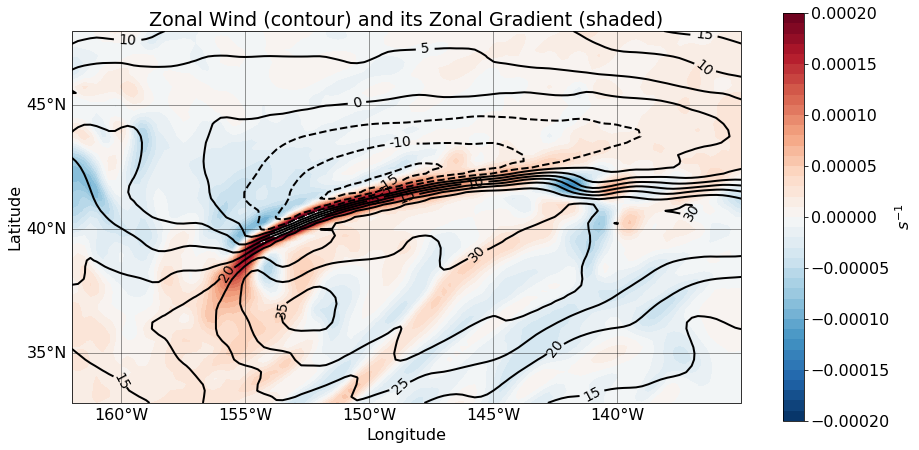

In [12]:
# an example of how to calculate zonal advection (-u*du/dx)
# first calculate zonal gradient of zonal wind (du/dx)
dudx = np.zeros((len(lat),len(lon)))*np.nan
dudx[:,1:-1]=(u[:,2:]-u[:,0:-2])/(x_mesh[:,2:]-x_mesh[:,0:-2]) # using centered differencing
dudx[:,0]=(u[:,1]-u[:,0])/(x_mesh[:,1]-x_mesh[:,0]) # forward differencing at the western domain edge
dudx[:,-1]=(u[:,-1]-u[:,-2])/(x_mesh[:,-1]-x_mesh[:,-2]) # backward differencing at the eastern domain edge
# calculate advection by muptiplying the gradient with -u
adv_x = -1*u*dudx



# one way to check if you have correctly calculated gradients is to plot them!
# Try plotting the gradient (du/dx) and u together to check if they make sense
fig = plt.figure(figsize=(15,15)) # create a figure
plt.rcParams.update({'font.size':16}) # change the font size
projection = ccrs.PlateCarree() # specify axes and projection option (see Cartopy website for the full list of projection types)
ax = plt.axes(projection=projection) 

# plot filled contours
longrid,latgrid=np.meshgrid(lon,lat) # create matrices of lat and lon that match the size of the variable you want to plot
ticks = np.arange(-20,21,1)*10**-5
plot1 = ax.contourf(longrid,latgrid,dudx,ticks,transform=projection,cmap="RdBu_r") # contour dudx
cbar = fig.colorbar(plot1,shrink=0.5) # add a colorbar
cbar.set_label('$s^{-1}$') # add units label to the colorbar
# add line contours
plot2 = ax.contour(longrid,latgrid,u,np.arange(-50,50,5),transform=projection,colors='k',linewidths=2) # contour u
ax.clabel(plot2, inline=True, fontsize=14, fmt='%d')
# add title
ax.set_title('Zonal Wind (contour) and its Zonal Gradient (shaded)') 

# add grid ticks
lontick = np.arange(-160,-135,5) # define longitude ticks
lattick = np.arange(35,50,5) # define latitude ticks
grl=ax.gridlines(crs=projection,draw_labels=True,color='k',alpha=0.5)
grl.top_labels = False
grl.right_labels = False
grl.xlocator = mticker.FixedLocator(lontick)
grl.ylocator = mticker.FixedLocator(lattick)

# to add x and y labels, add texts (set_xlabel and set_ylabel do not seem to work when you use Cartopy)
ax.text(np.mean(lon),np.min(lat)-1,'Longitude',ha='center',va='top')
ax.text(np.min(lon)-2,np.mean(lat),'Latitude',ha='right',va='center',rotation=90)

In [113]:
# calculate meridional advection in a similar manner


In [114]:
# an example of how to calculate vertical advection (-w*du/dp)
# calculate vertical gradient first
dudp1 = (u_lev2-u)/(100*(p2-p0)) # du/dp (m s-1 Pa-1) gradient with layer above
dudp2 = (u-u_lev1)/(100*(p0-p1)) # gradient with layer below
dudp = (dudp1+dudp2)/2 # take average vertical gradient
adv_z = -1*w*dudp


In [115]:
# other terms that you need to calculate are PGF and Coriolis
